In [12]:
# 需要先安裝 gym[atari]
# headless 執行: xvfb-run -a jupyter notebook
import gym

In [13]:
env = gym.make('Pong-ram-v0')

In [14]:
import numpy as np
import ipywidgets as W
from PIL import Image

看一下基本資訊

In [15]:
env.action_space

Discrete(6)

In [16]:
env.reward_range

(-inf, inf)

In [17]:
env.reset()

array([192,   0,   0,   0, 110,  38,   0,   7,  71,   1,  60,  59,   0,
         0,   0,  62, 255,   0, 255, 253,   0,  22,   0,  24, 128,  32,
         1,  86, 247,  86, 247,  86, 247, 134, 243, 245, 243, 240, 240,
       242, 242,  32,  32,  64,  64,  64, 188,  65, 189,   0,  22, 109,
        37,  37,  60,   0,   0,   0,   0, 109, 109,  37,  37, 192, 192,
       192, 192,   1, 192, 202, 247, 202, 247, 202, 247, 202, 247,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  54, 236, 242, 121, 240], dtype=uint8)

抓圖出來

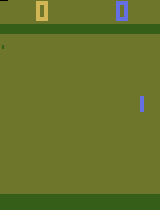

In [18]:
Image.fromarray(env.render(mode='rgb_array'))

In [19]:
from io import BytesIO
def to_png(a):
    with BytesIO() as bio:
        Image.fromarray(a).save(bio, 'png')
        return bio.getvalue()

觀察

In [20]:
from functools import partial
last_ob = None
def pressed(a, x):
    global last_ob
    observation, reward, done, info = env.step(a)
    img = env.render(mode='rgb_array')
    screen.value = to_png(img)
    txt.value = "{} {} {} {:02x} {:02x} {:02x}".format(reward, done, info, 
                                                       observation[49],observation[54], observation[60] )
    h = "<table>"
    for i in range(8):
        h+="<tr>"
        for j in range(16):
            color = 'black'
            if last_ob is not None:
                if last_ob[16*i+j]!=observation[16*i+j]:
                    color='red'
            h+="<td style='width: 2.5em;color: %s'>%02X</td>"%(color, observation[16*i+j])
        h+="</tr>"
    h+="</table"
    html.value=h
    last_ob = observation.copy()
buttons = [W.Button(description=str(i)) for i in range(6)]
for i in range(6):
    buttons[i].on_click(partial(pressed,i))
txt = W.Text()
env.reset()
screen = W.Image(value=to_png(env.render(mode='rgb_array')))
html = W.HTML()
display(W.HBox([screen, W.VBox(buttons), W.VBox([txt, html])]))



找到適當參數後， 手刻 AI

In [21]:
from time import sleep
screen = W.Image()
display(screen)
observation = env.reset()
wait = 0
for i in range(50):
    env.step(0)
for i in range(2000):
    x,y0 = observation[[49,54]]
    y2 = observation[60]
    dy = (observation[56]+127)%256-127
    dx = (observation[58]+127)%256-127
    if dx < 0:
        y = (int(y0 - (186-x)*dy/dx)-44)%(326)
        if y>163:
            y=326-y
        y+=38
    else:
        y=115
    if y2<y-3:
        if 40<y-y2 or wait<=0:
            a = 3
            wait=(40-(y-y2))//8
        else:
            wait-=1
            a=0
    elif y2 > y+3:
        if y2-y>40 or wait<=0:
            a = 2
            wait=(40-(y2-y))//8
        else:
            wait-=1
            a = 0
    else:
        a = 0
        wait =0
    observation, reward, done, info = env.step(a)
    img = env.render(mode='rgb_array')
    screen.value = to_png(img)
    sleep(1/60)

Image(value=b'')

用 Tabular Q learning 試試看， 狀態為預測的落點以及目前的位置之間的差距

In [11]:
from time import sleep
from random import randint, random, shuffle, choice

α = 3e-2
γ = 0.9
ϵ = .1

Q=np.zeros((100,3))
actions = [0,2,3]
def compute_s(observation):
    dx = (observation[58]+127)%256-127
    if dx>=0:
        return 0
    dy = (observation[56]+127)%256-127
    x,y0 = observation[[49,54]]
    y2 = observation[60]    
    y = (int(y0 - (186-x)*dy/dx)-44)%(326)
    if y>163:
        y=326-y
    y+=38
    s = (y-y2)//2
    if s<-49:
        s=-49
    elif s>49:
        s=49
    return s+50

def Qlearn(test=False, screen=None, T=40):
    observation = env.reset()
    for i in range(50):
        observation, reward, done, info =env.step(0)
    s2 = compute_s(observation)
    total_r = 0
    for i in range(T):
        s = s2
        if not test and random()< ϵ:
            a = choice(actions)
        elif s !=0:
            a = choice(actions)
        else:
            a = actions[np.argmax(Q[s])]
        observation, reward, done, info = env.step(a)        
        s2 = compute_s(observation)
        r = reward
        total_r+=r
        if not test and s!=0:
            if s2==0:
                r=1
            a = max(0, a-1)
            Q[s][a] += α*(r+γ*Q[s2].max() - Q[s][a])
            #if r!=0:
                #return total_r
        if screen is not None:
            img = env.render(mode='rgb_array')
            screen.value = to_png(img)
            sleep(1/60)
    return total_r

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

In [13]:
plt.ioff()
screen = W.Image()
display(screen)
txt =W.Text()
display(txt)
ϵ = .1
α = 1e-2
γ = 1
r = -20
for j in range(1001):
    if j%20==0:
        txt.value="j={} r={} {} ".format(j, r/20,  ϵ)
        plt.clf()
        plt.plot(Q[1:].max(axis=1))
        with BytesIO() as bio:
            plt.savefig(bio)            
            screen.value = bio.getvalue()
        if j%200==0:
            r=sum(Qlearn(test=True) for i in range(100))
            print(j, r/100, ϵ)
        r=0
    r+=Qlearn()


Image(value=b'')

Text(value='')

0 -0.85 0.1
200 -0.85 0.1
400 -0.78 0.1
600 -0.83 0.1
800 -0.89 0.1
1000 -0.85 0.1


### 測試一下

In [15]:
screen = W.Image()
display(screen)
Qlearn(test=True, screen=screen, T=40)

Image(value=b'')

-1.0

### 多打幾球

In [16]:
plt.ioff()
screen = W.Image()
display(screen)
txt =W.Text()
display(txt)
ϵ = .1
α = 1e-2
γ = 1
for j in range(1001):
    if j%10==0:
        txt.value="j={} r={} {} ".format(j, r/10,  ϵ)
        plt.clf()
        plt.plot(Q[1:].max(axis=1))
        with BytesIO() as bio:
            plt.savefig(bio)            
            screen.value = bio.getvalue()
        if j%200==0:
            r=sum(Qlearn(test=True, T=400) for i in range(20))
            print(j, r/20, ϵ)
        r=0

    r+=Qlearn(T=400)


Image(value=b'')

Text(value='')

0 -6.8 0.1
200 -5.95 0.1
400 -7.15 0.1
600 -6.2 0.1
800 -6.55 0.1
1000 -6.95 0.1


In [17]:
# 測試一下
screen = W.Image()
display(screen)
Qlearn(test=True, screen=screen, T=400)

Image(value=b'')

-7.0

## 把前一個動作也當成狀態

In [47]:
from time import sleep
from random import randint, random, shuffle, choice

α = 1e-2
γ = 0.9
ϵ = .1

Q=np.zeros((3, 100,3))
actions = [0,2,3]
last_a=0
def compute_s(observation, a):
    global last_a
    a = max(0, a-1)
    last_a, a0 = a, last_a
    dx = (observation[58]+127)%256-127
    if dx>=0:
        return 0    
    dy = (observation[56]+127)%256-127
    x,y0 = observation[[49,54]]
    y2 = observation[60]    
    y = (int(y0 - (186-x)*dy/dx)-44)%(326)
    if y>163:
        y=326-y
    y+=38
    s = (y-y2)//2
    if s<-49:
        s=-49
    elif s>49:
        s=49
    return a0, s+50

def Qlearn(test=False, screen=None, T=40):
    observation = env.reset()
    for i in range(50):
        a = choice(actions)
        observation, reward, done, info =env.step(a)
        s2 = compute_s(observation, a)
    total_r = 0
    for i in range(T):
        s = s2
        if not test and random()< ϵ:
            a = choice(actions)
        elif s==0:
            a = choice(actions)
        else:            
            a = actions[np.argmax(Q[s])]
        observation, reward, done, info = env.step(a)        
        s2 = compute_s(observation, a)
        r = reward
        total_r+=r
        if not test and s!=0:
            if s2==0:
                r=1
            a = max(0, a-1)
            Q[s][a] += α*(r+γ*Q[s2].max() - Q[s][a])
            #if r!=0:
                #return total_r
        if screen is not None:
            img = env.render(mode='rgb_array')
            screen.value = to_png(img)
            sleep(1/60)
    return total_r

<IPython.core.display.Javascript object>


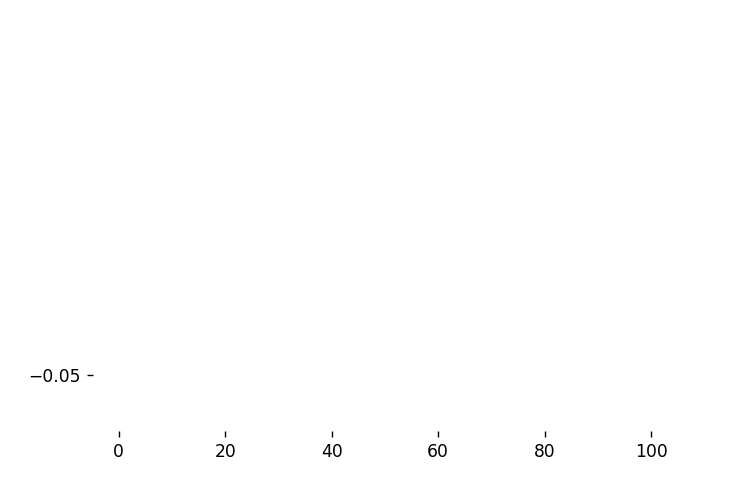

Text(value='')

In [48]:
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as W
plt.ion()
fig = plt.figure()
ax = fig.gca()
txt =W.Text()
display(txt)

In [49]:
ϵ = 3.1
α = 1e-2
γ = 1
for j in range(2001):
    if j%20==0:
        txt.value="j={} r={} {} ".format(j, r/20,  ϵ)
        if j%200==0:
            r=sum(Qlearn(test=True, T=400) for i in range(20))
            print(j, r/20, ϵ)
        r=0
    r+=Qlearn(T=400)
    ax.clear()
    for i,c in enumerate('rgb'):
        ax.plot(Q[i, 1:].max(axis=1), c)
    fig.canvas.draw()
    ϵ = max(0.1, ϵ*0.99)

0 -7.2 3.1
200 -3.95 0.4153369920596814
400 -2.45 0.1


KeyboardInterrupt: 

## 直接用原來的狀態，會有比較大的 state space

狀態太大，要花比較久的時間學習


In [50]:
from time import sleep
from random import randint, random, shuffle, choice
# x y0 y2 dy, a
Q=np.zeros((105, 105, 105, 20, 3))
actions = [0,2,3]
def compute_s(observation):
    dx = (observation[58]+127)%256-127
    if dx>=0:
        return None
    dy = (observation[56]+127)%256-127
    x,y0 = observation[[49,54]]
    y2 = observation[60]
    assert 0<=x<210
    assert -9<=dy<=9
    return (x//2,y0//2,y2//2,dy+9)

def Qlearn2(test=False, screen=None, T=300):
    observation = env.reset()
    for i in range(50):
        observation, reward, done, info =env.step(0)
    s2 = compute_s(observation)
    total_r = 0
    for i in range(T):
        s = s2
        if not test and random()< ϵ:
            a = choice(actions)
        elif s is None:
            a = choice(actions)
        else:
            try:
                a = actions[np.argmax(Q[s])]
            except:
                print(s)
        observation, reward, done, info = env.step(a)        
        s2 = compute_s(observation)
        r = reward
        total_r+=r
        if not test and s is not None:
            if s2 is None:
                r=1.
            a = max(0, a-1)
            Q[s][a] += α*(r+γ*Q[s2].max() - Q[s][a])
        if screen is not None:
            img = env.render(mode='rgb_array')
            screen.value = to_png(img)
            sleep(1/60)
    return total_r

In [ ]:
%matplotlib inline
plt.ioff()
screen = W.Image()
display(screen)
α = 3e-2
γ = 1
ϵ = .1
txt =W.Text()
display(txt)
rr= -8
rate = []
for j in range(20001):
    if j%100==99:
        r=sum(Qlearn2(test=True, T=400) for i in range(10))
        print(j, r/10)
    rr = rr*0.9 + 0.1*Qlearn2(T=400)
    rate.append(rr)
    txt.value="j={} r={}".format(j,rr)
    plt.clf()
    plt.plot(rate)
    with BytesIO() as bio:
        plt.savefig(bio)
        screen.value = bio.getvalue()


Image(value=b'')

Text(value='')

99 -8.0


In [ ]:
# 測試
screen = W.Image()
display(screen)
Qlearn2(test=True, screen=screen, T=400)